In [1]:
%load_ext autoreload
%autoreload 2

from setup_func import *

from kkplot import performance_comp, plot_sig_predictive, plot_sig_improvement, plot_sig_improvement2, plot_r2_adj, plot_posterior_predictive, generate_param_estimates_df, plot_from_df

## Load master dataframes

In [2]:
alcohol_master_df = pd.read_csv(f'{data_dir}/glm_master_csvs/sudonly_addictive_alcohol_master_df.csv', index_col=0)
cannabis_master_df = pd.read_csv(f'{data_dir}/glm_master_csvs/sudonly_addictive_cannabis_master_df.csv', index_col=0)

In [3]:
alcohol_master_df['DEMO_race_old'] = alcohol_master_df['DEMO_race'].copy()
# Create a new column 'DEMO_race_new' that has only 2 categories: White and Non-White
DEMO_race_new = []
for i in alcohol_master_df['DEMO_race']:
    if i == 'White':
        DEMO_race_new.append('White')
    else:
        DEMO_race_new.append('NonWhite')
alcohol_master_df['DEMO_race'] = DEMO_race_new

cannabis_master_df['DEMO_race_old'] = cannabis_master_df['DEMO_race'].copy()
# Create a new column 'DEMO_race_new' that has only 2 categories: White and Non-White
DEMO_race_new = []
for i in cannabis_master_df['DEMO_race']:
    if i == 'White':
        DEMO_race_new.append('White')
    else:
        DEMO_race_new.append('NonWhite')
cannabis_master_df['DEMO_race'] = DEMO_race_new

cannabis_master_df

,ASSIST_Cannabis,ASSIST_Freq,ASSIST_Craving,ASSIST_StopAttempt,age,sex,edu_level,income,race,PID,...,DEMO_race,Block,alpha,beta,craving_baseline,ev_weight,gamma,mod,rpe_weight,DEMO_race_old
0,12.0,6.0,3.0,0.0,44.0,1.0,4.0,3.0,7,5dd42e7f35cf744223c60d1b,...,White,other,0.871364,2.894182,29.200782,0.115453,0.973185,-0.519871,-1.841441,White
1,5.0,2.0,0.0,0.0,37.0,2.0,6.0,9.0,7,5bebd4111296920001d55c5a,...,White,other,0.816739,6.160160,2.303292,-0.258488,0.375280,-2.174133,0.184977,White
2,8.0,2.0,3.0,0.0,60.0,2.0,5.0,11.0,7,5ec2feeb47c4471339d3b2ce,...,White,other,0.854741,6.252317,33.842405,-1.131622,0.997649,-0.694686,-2.537110,White
3,6.0,3.0,0.0,0.0,32.0,1.0,6.0,11.0,7,5f80bc44efa2c013099af460,...,White,other,0.813308,4.118180,3.418341,-0.309691,0.187201,-1.245153,-0.497486,White
4,12.0,6.0,3.0,0.0,39.0,1.0,6.0,11.0,7,601e1253bbecc3279e4fb472,...,White,other,0.814744,4.253366,22.245896,-1.133518,0.771724,-0.796318,-1.419076,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,33.0,6.0,6.0,6.0,36.0,1.0,3.0,8.0,4,5f878ac24e7e5f1ba4237c09,...,NonWhite,other,0.572286,4.240085,-0.617048,1.649382,0.860051,-5.977397,0.771341,HispanicorLatino
60,7.0,4.0,0.0,0.0,27.0,1.0,5.0,3.0,7,5be9d049e1b58b0001e13001,...,White,other,0.812700,4.116680,9.709824,0.789349,0.956958,-0.345781,0.606391,White
61,12.0,4.0,5.0,0.0,54.0,2.0,5.0,8.0,7,5c44cf2da5487b00011d0b80,...,White,other,0.713521,3.735471,28.892136,0.212059,0.984697,-3.242895,3.011017,White
62,15.0,6.0,6.0,0.0,36.0,1.0,6.0,12.0,7,5aadbe52811b2000016f7633,...,White,other,0.796931,2.053124,26.810826,0.077149,0.992508,-0.378423,-0.951587,White


## Functions

In [4]:
## Regression functions

def get_normed_model(mdf, reg_params, model_name, block):
    _model_df = mdf.loc[
        (mdf['Group']==reg_params['group']) &
        (mdf['Model']==model_name) & 
        (mdf['Block']==block)
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=reg_params['dependent_var']).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (reg_params['full_param_list']+reg_params['full_demo_list']+reg_params['full_nonmodel_param_list']):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [reg_params['dependent_var']] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_race'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    return normed_model_df, scaler

def build_equation(nmdf, reg_params, typ):
    # Build the model equation
    equation = reg_params['dependent_var'] + ' ~ '
    model_param_names = []
    if typ in ['comp', 'democomp']:
        for param in reg_params['full_param_list']:
            if param in nmdf.columns:
                equation += param + ' + '
                model_param_names.append(param)
    if typ in ['magnos', 'demomagnos']:
        for param in reg_params['full_nonmodel_param_list']:
            if param in nmdf.columns:
                equation += param + ' + '
                model_param_names.append(param)
    if typ in ['demo', 'democomp', 'demomagnos']:
        for demo in reg_params['full_demo_list']:
            for col in nmdf.columns:
                if demo in col:
                    equation += col + ' + '
                    model_param_names.append(col)
    equation = equation[:-3]
    # print(f'Number {i}:\t{model_name}\t{equation}')
    return equation

def fit_unfiltered(equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params):
    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=nmdf).fit()
    # display(sm_results.summary())
    sm_model_dict[model_name] = sm_results

    if reg_params['bambi_flag']:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, nmdf, family=reg_params['family'])
        bmb_results = bmb_model.fit(idata_kwargs={'log_likelihood': True})
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bmb_model_dict[model_name] = bmb_results
    
    return sm_model_dict, bmb_model_dict

def build_filtered_equation(equation, nmdf, reg_params):
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    success = True
    while least_sig > reg_params['sig_threshold']:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=nmdf).fit()
        except:
            success = False
            break
        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > reg_params['sig_threshold']:
            filtered_equation = reg_params['dependent_var'] + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = reg_params['dependent_var'] + ' ~ ' + ' + '.join(predictors)
    # print(f'Number {i}:\t{model_name}\t{filtered_equation}')
    return filtered_equation, success

def fit_filtered(filtered_equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params):
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=nmdf).fit()
    # display(filtered_sm_results.summary())
    sm_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if reg_params['bambi_flag']:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, nmdf, family=reg_params['family'])
        filtered_bmb_results = filtered_bmb_model.fit(idata_kwargs={'log_likelihood': True})
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bmb_model_dict[f'{model_name}_filtered'] = filtered_bmb_results
    
    return sm_model_dict, bmb_model_dict

def run_group_regression(
    mdf,
    group,
    model_names,
    dependent_var,
    typ,
    block,
    sm_model_dict=None,
    bmb_model_dict=None,
    full_demo_list=['age', 'DEMO_sex', 'edu_level', 'DEMO_race', 'income'],
    full_param_list = ['alpha', 'beta', 'craving_baseline', 'gamma', 'rpe_weight', 'ev_weight', 'mod'],
    full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'other_optimality'],
    family = 'gaussian',
    bambi_flag = True,
    sig_threshold = 0.05,
    filter_flag = False
):
    if typ not in ['demo', 'comp', 'magnos', 'democomp', 'demomagnos']:
        raise ValueError('typ must be one of "demo", "comp", "magnos", "democomp", or "demomagnos"')
    reg_params = {
        'group': group,
        'dependent_var': dependent_var,
        'full_demo_list': full_demo_list,
        'full_param_list': full_param_list,
        'full_nonmodel_param_list': full_nonmodel_param_list,
        'family': family,
        'bambi_flag': bambi_flag,
        'sig_threshold': sig_threshold,
    }
    if sm_model_dict is None:
        print('sm_model_dict is None')
        sm_model_dict = {}
    if bmb_model_dict is None:
        bmb_model_dict = {}

    for model_name in model_names:
        nmdf, model_scaler = get_normed_model(mdf, reg_params, model_name, block)
        # print(f'Number of participants: {len(nmdf)}')

        # Rename model_name
        if typ=='demo':
            model_name = f'demo_{model_name}'
        elif typ=='comp':
            model_name = f'comp_{model_name}'
        elif typ=='magnos':
            model_name = f'magnos_{model_name}'
        elif typ=='democomp':
            model_name = f'democomp_{model_name}'
        elif typ=='demomagnos':
            model_name = f'demomagnos_{model_name}'

        print(f'Running regression for {typ} - {group} {model_name} {dependent_var}...')
        equation = build_equation(nmdf, reg_params, typ)
        # print(f'{model_name}\t{equation}')
        sm_model_dict, bmb_model_dict = fit_unfiltered(equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params)
        if filter_flag:
            filtered_equation, success = build_filtered_equation(equation, nmdf, reg_params)
            if success:
                # print('Successful filtering')
                # print(f'{model_name}\t{filtered_equation}')
                sm_model_dict, bmb_model_dict = fit_filtered(filtered_equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params)
    return sm_model_dict, bmb_model_dict, reg_params, model_scaler


###

## Alcohol analysis

In [5]:
alcohol_master_df['money_optimality'] = alcohol_master_df['Money Accuracy']
alcohol_master_df['other_optimality'] = alcohol_master_df['Other Accuracy']

In [6]:
alcohol_master_df['Model'] = 'd_lrbias_rw'

In [8]:
alcohol_master_df

,ASSIST_Alcohol,ASSIST_Freq,ASSIST_Craving,ASSIST_StopAttempt,age,sex,edu_level,income,race,PID,...,beta,craving_baseline,ev_weight,gamma,mod,rpe_weight,DEMO_race_old,money_optimality,other_optimality,Model
0,5.0,2.0,0.0,0.0,19.0,2.0,3.0,1.0,2,6111c95332b4f21de44a25c7,...,3.529321,3.658436,-0.019536,0.989964,-1.823528,0.788772,Asian,0.833333,0.766667,d_lrbias_rw
1,7.0,4.0,0.0,0.0,52.0,2.0,4.0,4.0,7,5edf9f945600b52832384409,...,5.449954,23.080062,0.194389,0.981265,0.517934,-0.488249,White,0.733333,0.766667,d_lrbias_rw
2,20.0,4.0,6.0,0.0,27.0,2.0,6.0,7.0,7,60fee74fa3b33a3312af7568,...,1.136403,27.100031,0.308135,0.942536,0.749736,1.318316,White,0.583333,0.616667,d_lrbias_rw
3,10.0,4.0,3.0,0.0,59.0,1.0,4.0,8.0,7,58064d91f25c440001678a10,...,6.007890,2.025787,0.736407,0.990950,0.450314,1.975841,White,0.750000,0.733333,d_lrbias_rw
4,6.0,3.0,0.0,0.0,34.0,1.0,6.0,6.0,2,5e67f0321e4f0a0a657c1d08,...,4.598111,18.184546,-0.224082,0.995099,0.710194,-0.029978,Asian,0.700000,0.600000,d_lrbias_rw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,22.0,4.0,5.0,6.0,43.0,1.0,6.0,4.0,7,616567af93f2b71b50c3ff85,...,4.006465,42.051381,-0.309163,0.982326,0.834326,-1.676358,White,0.800000,0.700000,d_lrbias_rw
64,31.0,4.0,5.0,6.0,35.0,2.0,4.0,2.0,1,56849d528f456f000c45e1dd,...,1.236585,24.657072,0.016050,0.985680,0.230134,-0.179905,AmericanIndianorAlaskaNative,0.633333,0.650000,d_lrbias_rw
65,28.0,6.0,5.0,6.0,39.0,2.0,3.0,8.0,7,58a43e029a17120001d910d5,...,4.766500,28.317684,0.111596,0.906605,-0.362709,0.098126,White,0.716667,0.766667,d_lrbias_rw
66,21.0,4.0,5.0,6.0,24.0,1.0,5.0,10.0,7,5cf91ace3bb7c4000162318c,...,4.894192,22.062187,0.032969,0.989345,0.873011,-0.198071,White,0.850000,0.783333,d_lrbias_rw


In [9]:
alc_sm_model_dict = {}
alc_bmb_model_dict = {}
alc_scalers = {}
# for typ in ['comp', 'nonmodel', 'combined']:
for typ in ['demo', 'comp', 'magnos', 'democomp', 'demomagnos']:
    alc_sm_model_dict, alc_bmb_model_dict, alc_reg_params, alc_model_scaler = run_group_regression(
        mdf=alcohol_master_df,
        model_names=['d_lrbias_rw'],
        group='alcohol',
        dependent_var='ASSIST_Alcohol',
        typ=typ,
        block='other',
        sm_model_dict=alc_sm_model_dict,
        bmb_model_dict=alc_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.15,
        filter_flag=False
    )
    alc_scalers[typ] = alc_model_scaler

Running regression for demo - alcohol demo_d_lrbias_rw ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Alcohol_sigma, Intercept, age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Running regression for comp - alcohol comp_d_lrbias_rw ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Alcohol_sigma, Intercept, alpha, beta, craving_baseline, gamma, rpe_weight, ev_weight, mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Running regression for magnos - alcohol magnos_d_lrbias_rw ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Alcohol_sigma, Intercept, mean_craving_ratings, std_craving_ratings, other_optimality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for democomp - alcohol democomp_d_lrbias_rw ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Alcohol_sigma, Intercept, alpha, beta, craving_baseline, gamma, rpe_weight, ev_weight, mod, age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Running regression for demomagnos - alcohol demomagnos_d_lrbias_rw ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Alcohol_sigma, Intercept, mean_craving_ratings, std_craving_ratings, other_optimality, age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


,Model,R2,R2_adj,AIC,BIC
0,comp_d_lrbias_rw,0.310975,0.230588,183.647202,201.403264
1,magnos_d_lrbias_rw,0.149058,0.109170,189.999710,198.877741
2,democomp_d_lrbias_rw,0.350189,0.193752,191.662671,222.735779
3,demomagnos_d_lrbias_rw,0.231398,0.112132,195.079278,217.274355
4,demo_d_lrbias_rw,0.074782,-0.016223,201.690300,217.226854


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
comp_d_lrbias_rw,0,-93.557372,8.528619,0.000000,0.712554,5.217340,0.000000,True,log
magnos_d_lrbias_rw,1,-95.632676,3.810661,2.075303,0.154595,4.835412,3.327837,False,log
democomp_d_lrbias_rw,2,-97.914431,12.719517,4.357059,0.000000,4.811238,2.233747,True,log
demomagnos_d_lrbias_rw,3,-98.689556,8.990776,5.132183,0.132850,5.320240,4.528102,True,log
demo_d_lrbias_rw,4,-101.896038,6.841883,8.338665,0.000000,5.328925,4.654711,True,log


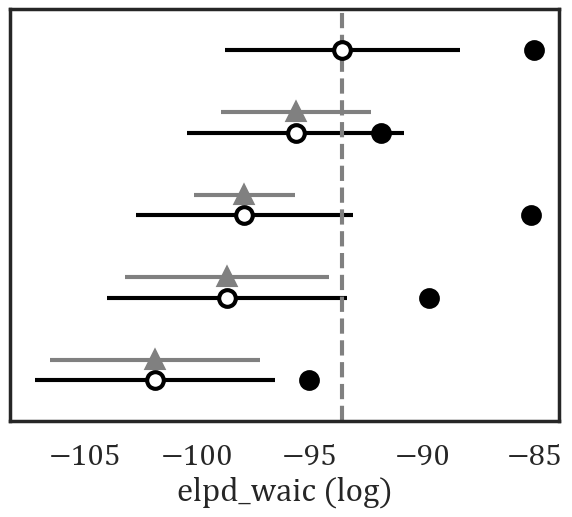

In [10]:
# mm = 1/25.4*4
alc_perf_df, comp_fig, comp_ax = performance_comp_redux(alc_sm_model_dict, alc_bmb_model_dict, figsize=(45*mm, 34*mm), bambi_flag=True)
plt.savefig(f'{figure_dir}/fig4_alcohol_reg_comp.svg', format='svg', dpi=300, transparent=True)

Demo: r=0.592, p=0.000
Comp: r=0.553, p=0.000
Magnos: r=0.386, p=0.001
Democomp: r=0.592, p=0.000
Demomagnos: r=0.481, p=0.000


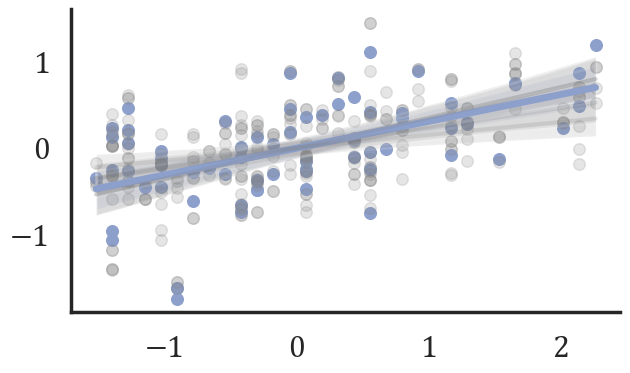

In [13]:
pred_fig, pred_ax = plot_posterior_predictive_redux(alc_bmb_model_dict, alc_perf_df, alc_reg_params, 'alcohol', figsize=(45*mm, 25*mm))
# plt.savefig(f'{figure_dir}/fig4_alcohol_posterior_predictive.svg', format='svg', dpi=300, transparent=True)

[Text(0, 0.0, 'Mod'),
 Text(0, 1.3499999999999999, 'EV weight'),
 Text(0, 2.6999999999999997, 'RPE weight'),
 Text(0, 4.049999999999999, 'Craving baseline'),
 Text(0, 5.399999999999999, 'Inv Temperature'),
 Text(0, 6.749999999999998, 'Learning Rate')]

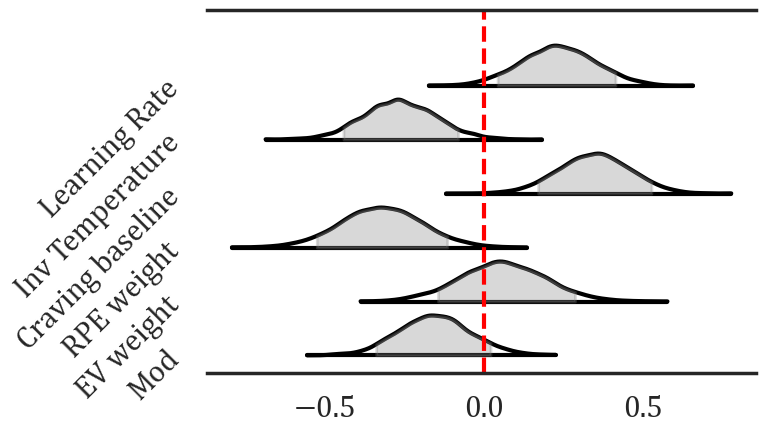

In [83]:
# Forest plot of alc_bmb_model_dict[alc_perf_df.iloc[0]['Model']]
label_dict = {
    'alpha': 'Learning Rate',
    'beta': 'Inv Temperature',
    'craving_baseline': 'Craving baseline',
    'gamma': 'Gamma',
    'rpe_weight': 'RPE weight',
    'ev_weight': 'EV weight',
    'mod': 'Mod',
    'mean_craving_ratings': 'Mean Craving',
    'std_craving_ratings': 'St.D. Craving',
    'mean_mood_ratings': 'Mean Mood',
    'std_mood_ratings': 'St.D. Mood',
    'money_optimality': 'Money Optimality',
    'other_optimality': 'Addictive Optimality',
    'age': 'Age',
    'income': 'Income',
    # 'DEMO_race_Asian': 'Asian',
    'ASSIST_Alcohol_mean': 'ASSIST Alcohol Mean',
}
var_list = [elem for elem in alc_bmb_model_dict[alc_perf_df.iloc[0]['Model']].posterior.data_vars if elem not in ['Intercept', 'ASSIST_Alcohol_sigma', 'ASSIST_Alcohol_mean', "gamma"]]
# mm = 1/25.4*4
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(45*mm, 30*mm))
az.plot_forest(alc_bmb_model_dict[alc_perf_df.iloc[0]['Model']], combined=True, hdi_prob=0.89, kind='ridgeplot', ridgeplot_overlap=1, ridgeplot_truncate=False, ridgeplot_alpha=0.3, colors='gray', var_names=var_list, ax=ax)
ax.axvline(0, color='red', linestyle='--')
ax.set_yticklabels([])
# plt.savefig(f'/Users/kulkarnik/LocalProjects/SlotsTasks_simplified_rhoads/outputs/figures/alcohol_reg_forest.svg', format='svg', dpi=300, transparent=True)
plt.savefig(f'{figure_dir}/fig4_alcohol_reg_forest.svg', format='svg', dpi=300, transparent=True)
ax.set_yticklabels(reversed([label_dict[elem] for elem in var_list]), rotation=45, ha='right')

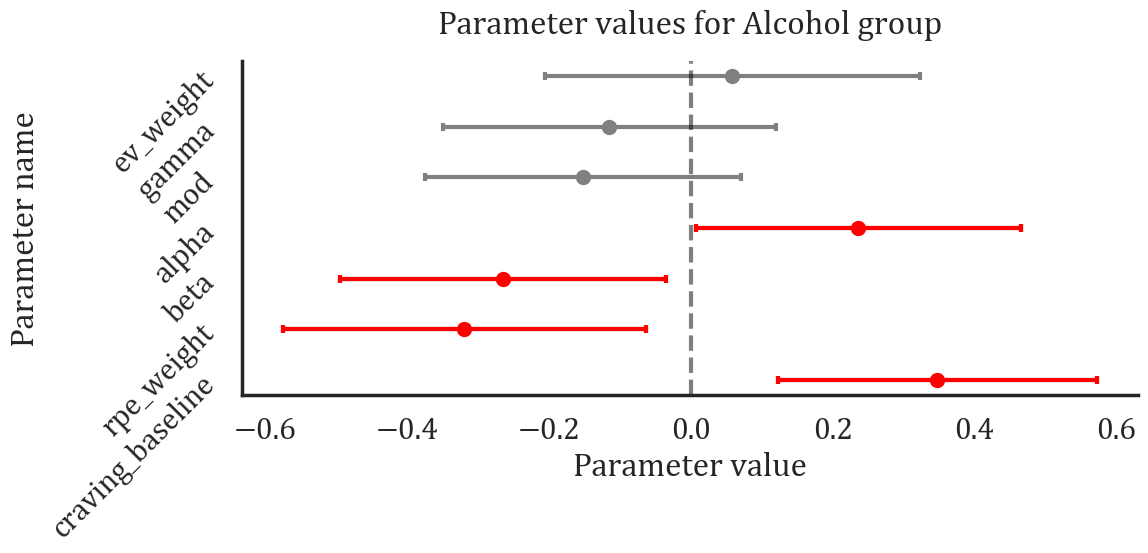

In [61]:
alc_glm_params_df = generate_param_estimates_df(alc_sm_model_dict[alc_perf_df.iloc[0]['Model']], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=alc_glm_params_df, ax=ax, group='Alcohol')
plt.tight_layout()

## Cannabis analysis

In [14]:
cannabis_master_df['Model'] = 'd_lrbias_rw'
cannabis_master_df['money_optimality'] = cannabis_master_df['Money Accuracy']
cannabis_master_df['other_optimality'] = cannabis_master_df['Other Accuracy']

In [15]:
can_sm_model_dict = {}
can_bmb_model_dict = {}
can_scalers = {}
# for typ in ['comp', 'nonmodel', 'combined']:
# for typ in ['comp', 'nonmodel']:
for typ in ['demo', 'comp', 'magnos', 'democomp', 'demomagnos']:
    can_sm_model_dict, can_bmb_model_dict, can_reg_params, can_model_scaler = run_group_regression(
        mdf=cannabis_master_df,
        model_names=['d_lrbias_rw'],
        group='cannabis',
        dependent_var='ASSIST_Cannabis',
        typ=typ,
        block='other',
        sm_model_dict=can_sm_model_dict,
        bmb_model_dict=can_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.15,
        filter_flag=False
    )
    can_scalers[typ] = can_model_scaler

Running regression for demo - cannabis demo_d_lrbias_rw ASSIST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Cannabis_sigma, Intercept, age, DEMO_sex_Female, DEMO_sex_Male, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Running regression for comp - cannabis comp_d_lrbias_rw ASSIST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Cannabis_sigma, Intercept, alpha, beta, craving_baseline, gamma, rpe_weight, ev_weight, mod]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Running regression for magnos - cannabis magnos_d_lrbias_rw ASSIST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Cannabis_sigma, Intercept, mean_craving_ratings, std_craving_ratings, other_optimality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for democomp - cannabis democomp_d_lrbias_rw ASSIST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Cannabis_sigma, Intercept, alpha, beta, craving_baseline, gamma, rpe_weight, ev_weight, mod, age, DEMO_sex_Female, DEMO_sex_Male, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Running regression for demomagnos - cannabis demomagnos_d_lrbias_rw ASSIST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ASSIST_Cannabis_sigma, Intercept, mean_craving_ratings, std_craving_ratings, other_optimality, age, DEMO_sex_Female, DEMO_sex_Male, edu_level, DEMO_race_NonWhite, DEMO_race_White, income]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


,Model,R2,R2_adj,AIC,BIC
0,demo_d_lrbias_rw,0.136306,0.061849,184.245792,197.199091
1,magnos_d_lrbias_rw,0.061940,0.015037,185.531885,194.167417
2,demomagnos_d_lrbias_rw,0.183988,0.065296,186.611234,206.041181
3,comp_d_lrbias_rw,0.089675,-0.024115,191.611073,208.882138
4,democomp_d_lrbias_rw,0.216600,0.032270,192.001012,220.066492


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
demo_d_lrbias_rw,0,-94.032539,7.616690,0.000000,5.247670e-01,6.690390,0.000000,True,log
magnos_d_lrbias_rw,1,-94.362524,5.480113,0.329984,4.752330e-01,7.116522,3.264152,True,log
demomagnos_d_lrbias_rw,2,-95.416427,9.943895,1.383887,0.000000e+00,7.212412,1.867800,True,log
comp_d_lrbias_rw,3,-98.825172,10.531975,4.792632,6.145582e-16,7.169568,3.445351,True,log
democomp_d_lrbias_rw,4,-99.236675,14.013480,5.204136,1.776357e-15,7.524309,2.589005,True,log


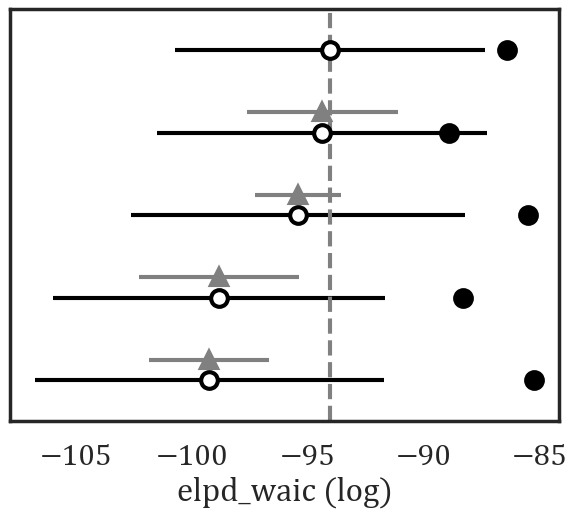

In [16]:
can_perf_df, comp_fig, comp_ax = performance_comp_redux(can_sm_model_dict, can_bmb_model_dict, figsize=(45*mm, 34*mm), bambi_flag=True)
plt.savefig(f'{figure_dir}/fig4_cannabis_reg_comp.svg', format='svg', dpi=300, transparent=True)

Demo: r=0.373, p=0.002
Comp: r=0.288, p=0.021
Magnos: r=0.241, p=0.055
Democomp: r=0.471, p=0.000
Demomagnos: r=0.426, p=0.000


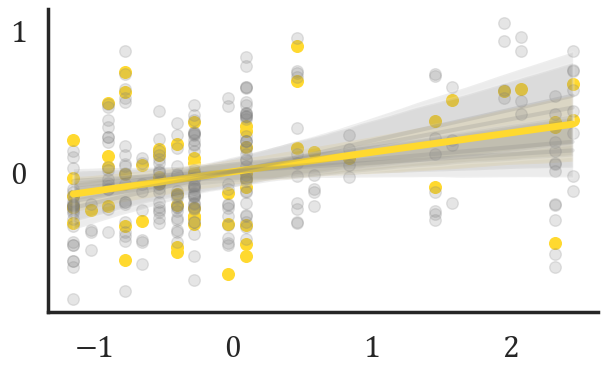

In [17]:
pred_fig, pred_ax = plot_posterior_predictive_redux(can_bmb_model_dict, can_perf_df, can_reg_params, 'cannabis', figsize=(45*mm, 25*mm))
# plt.savefig(f'{figure_dir}/fig4_cannabis_posterior_predictive.svg', format='svg', dpi=300, transparent=True)

[Text(0, 0.0, 'Income'),
 Text(0, 1.3499999999999999, 'Education'),
 Text(0, 2.6999999999999997, 'Age')]

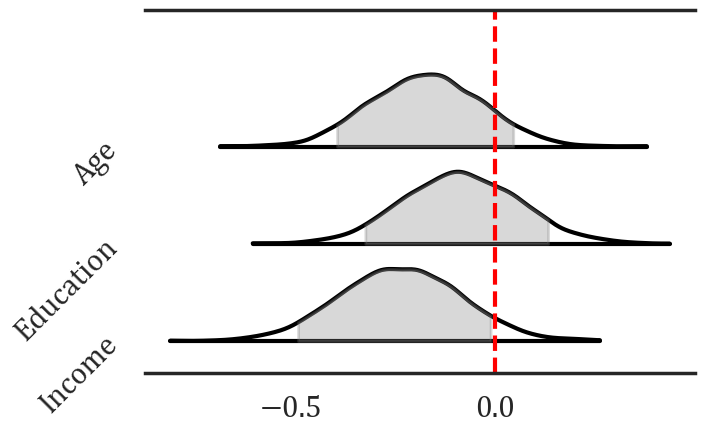

In [88]:
# Forest plot of can_bmb_model_dict[can_perf_df.iloc[0]['Model']]
label_dict = {
    'alpha': 'Learning Rate',
    'beta': 'Inv Temperature',
    'craving_baseline': 'Craving baseline',
    'gamma': 'Gamm',
    'rpe_weight': 'RPE weight',
    'ev_weight': 'EV weight',
    'mod': 'Mod',
    'mean_craving_ratings': 'Mean Craving',
    'std_craving_ratings': 'St.D. Craving',
    'mean_mood_ratings': 'Mean Mood',
    'std_mood_ratings': 'St.D. Mood',
    'money_optimality': 'Money Optimality',
    'other_optimality': 'Addictive Optimality',
    'age': 'Age',
    'income': 'Income',
    'edu_level': 'Education',
    'DEMO_sex_Female': 'Female',
    'DEMO_sex_Male': 'Male',
    'DEMO_race_NonWhite': 'NonWhite',
    'DEMO_race_White': 'White',
    # 'DEMO_race_AmericanIndianorAlaskaNative': 'American Indian',
    'ASSIST_Cannabis_mean': 'ASSIST Cannabis Mean',
}
var_list = [elem for elem in can_bmb_model_dict[can_perf_df.iloc[0]['Model']].posterior.data_vars if elem not in ['Intercept', 'ASSIST_Cannabis_sigma', 'ASSIST_Cannabis_mean', 'DEMO_sex_Female', 'DEMO_sex_Male', 'DEMO_race_NonWhite', 'DEMO_race_White']]
# mm = 1/25.4*4
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(45*mm, 30*mm))
az.plot_forest(can_bmb_model_dict[can_perf_df.iloc[0]['Model']], combined=True, hdi_prob=0.89, kind='ridgeplot', ridgeplot_overlap=1, ridgeplot_truncate=False, ridgeplot_alpha=0.3, colors='gray', var_names=var_list, ax=ax)
ax.axvline(0, color='red', linestyle='--')
ax.set_yticklabels([])
# ax.set_xlim(-1.2, 1.2)
# plt.savefig(f'/Users/kulkarnik/LocalProjects/SlotsTasks_simplified_rhoads/outputs/figures/cannabis_reg_forest.svg', format='svg', dpi=300, transparent=True)
plt.savefig(f'{figure_dir}/fig4_cannabis_reg_forest.svg', format='svg', dpi=300, transparent=True)
ax.set_yticklabels(reversed([label_dict[elem] for elem in var_list]), rotation=45, ha='right')

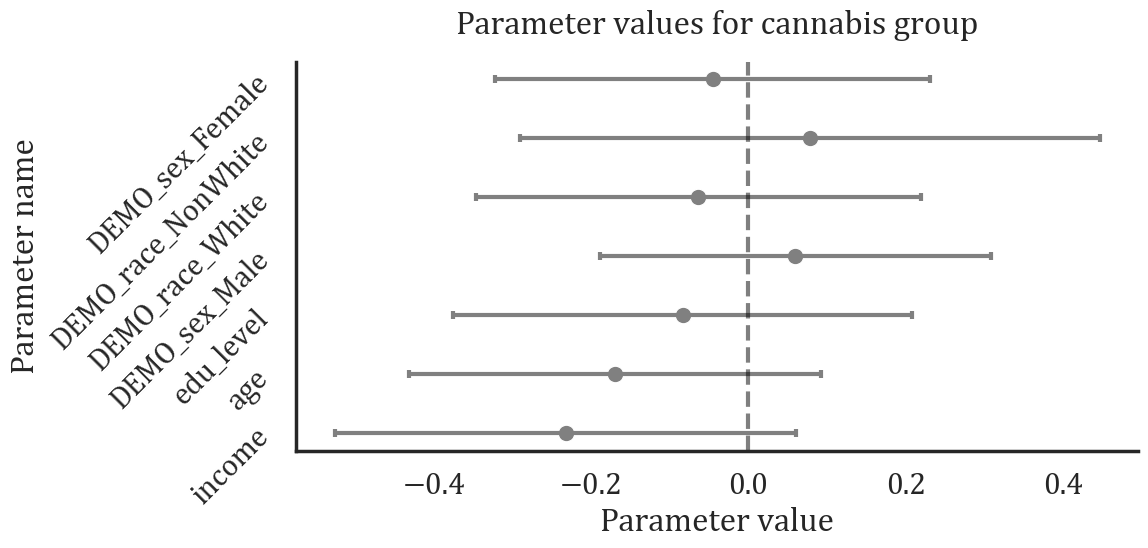

In [50]:
can_glm_params_df = generate_param_estimates_df(can_sm_model_dict[can_perf_df.iloc[0]['Model']], 'Cannabis')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=can_glm_params_df, ax=ax, group='cannabis')
plt.tight_layout()